In [1]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

In [2]:
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *

MAX_MEMORY = '4G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 100000) \
        .set('spark.network.timeout', 100000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
filename_data = 'data/archive/region25.csv'
# Load the main data set into pyspark data frame 
df = spark.read.csv(filename_data,header=True, mode="DROPMALFORMED")
df = df.union(spark.read.csv('data/archive/region41.csv', header=True, mode="DROPMALFORMED"))
print('Data frame type: ' + str(type(df)))

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


# **2. Overview of Dataset** <a class="anchor" id="2"></a>

[Go back to table of contents](#0.1)

### Schema, columns & datatypes of the data set:
   *The data set has both single value columns (int, string) and columns made of arrays/list.*

In [3]:
print('Data overview')
df.printSchema()
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Data overview
root
 |-- brand: string (nullable = true)
 |-- name: string (nullable = true)
 |-- bodyType: string (nullable = true)
 |-- color: string (nullable = true)
 |-- fuelType: string (nullable = true)
 |-- year: string (nullable = true)
 |-- mileage: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- power: string (nullable = true)
 |-- price: string (nullable = true)
 |-- vehicleConfiguration: string (nullable = true)
 |-- engineName: string (nullable = true)
 |-- engineDisplacement: string (nullable = true)
 |-- date: string (nullable = true)
 |-- location: string (nullable = true)
 |-- link: string (nullable = true)
 |-- description: string (nullable = true)
 |-- parse_date: string (nullable = true)

Columns overview


Column Name Data type
0                  brand    string
1                   name    string
2               bodyType    string
3                  color    string
4               fuelType    string
5                   year    string
6                mileage    string
7           transmission    string
8                  power    string
9                  price    string
10  vehicleConfiguration    string
11            engineName    string
12    engineDisplacement    string
13                  date    string
14              location    string
15                  link    string
16           description    string
17            parse_date    string

In [5]:
print('Data frame describe (string and numeric columns only):')
df.describe().toPandas()

print(f'There are total {df.count()} row, Let print first 2 data rows:')
df.limit(2).toPandas()

Data frame describe (string and numeric columns only):


summary    brand                name       bodyType    color fuelType  \
0   count  2239861             2239861        2239861  2123149  2232302   
1    mean     None  1855.7979997801956           None     None     None   
2  stddev     None   1040.724457707244           None     None     None   
3     min    Acura            1-Series     Джип 3 дв.  Бежевый   Бензин   
4     max      УАЗ              Хантер  Хэтчбек 5 дв.   Черный  Электро   

                 year             mileage transmission               power  \
0             1478615             2232419      2231469             2212395   
1  2007.6793134115371  160766.09408896806         None  150.73209621247562   
2   8.214653247716928   96521.18736892138         None   70.13622394274311   
3              1948.0              1000.0         АКПП               100.0   
4              2022.0            999000.0        Робот                99.0   

                price       vehicleConfiguration   engineName  \
0             2239861                    1478615      1478079   
1   1178912.739825373          6.445440357904585         None   
2  1368474.9532402533          39.45632582995471         None   
3               10000   1.0 CILQ G Package SAIII         10HM   
4              999999                  ГАЗ-М-21Л  УМЗ-4178.10   

  engineDisplacement                 date     location  \
0            1470604              2239861      2239861   
1               None                 None         None   
2               None                 None         None   
3            0.5 LTR  2022-08-03 00:00:00      Анучино   
4            6.4 LTR  2022-09-17 00:00:00  Ярославский   

                                                link  \
0                                            2239861   
1                                               None   
2                                               None   
3  https://anuchino.drom.ru/gaz/21_volga/47459483...   
4  https://zarubino.drom.ru/toyota/vista/48135042...   

                                         description           parse_date  
0                                            2165982              2239861  
1                                    8.9146877521E10                 None  
2                                                0.0                 None  
3  ! ! ! ПЕРЕКУПОВ ПРОСЬБА НЕ БЕСПОКОИТЬ ! ! !  Н...  2022-08-20 04:00:00  
4  …МАКСИМАЛЬНАЯ КОМПЛЕКТАЦИЯ F. SPORT …ПОЛНЫЙ КО...  2022-09-17 10:00:00

There are total 2358720 row, Let print first 2 data rows:


brand        name       bodyType   color fuelType  year  mileage  \
0  Fiat  124 Spider       Открытый   Синий   Бензин  None   8000.0   
1   BMW          i3  Хэтчбек 5 дв.  Черный  Электро  None  12000.0   

  transmission power    price vehicleConfiguration engineName  \
0      Автомат  None  1830000                 None       None   
1      Автомат  None  1830000                 None       None   

  engineDisplacement                 date     location  \
0               None  2022-08-20 00:00:00  Владивосток   
1               None  2022-08-20 00:00:00  Владивосток   

                                                link  \
0  https://vladivostok.drom.ru/fiat/124_spider/47...   
1   https://vladivostok.drom.ru/bmw/i3/47958301.html   

                                         description           parse_date  
0  Только сегодня с таможни забрали Как новый! Кр...  2022-08-20 04:00:00  
1  Электричка +двс V-600cc ,как новая BMW i3 с ге...  2022-08-20 04:00:00

# **3. Detect missing values and abnormal zeroes** <a class="anchor" id="3"></a>

[Go back to table of contents](#0.1)

After having a first sight of the columns, the first thing we should check is if the data set having any missing value.
- For string columns, we check for `None` and `null`
- For numeric columns, we check for zeroes and `NaN`
- For array type columns, we check if the array contain zeroes or `NaN`

In [6]:
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Columns overview


Column Name Data type
0                  brand    string
1                   name    string
2               bodyType    string
3                  color    string
4               fuelType    string
5                   year    string
6                mileage    string
7           transmission    string
8                  power    string
9                  price    string
10  vehicleConfiguration    string
11            engineName    string
12    engineDisplacement    string
13                  date    string
14              location    string
15                  link    string
16           description    string
17            parse_date    string

In [7]:
missing_values = {}
df = df.select("brand", "color", "fuelType", "year", "mileage", "transmission", "power", "price")
for index, column in enumerate(df.columns):
        missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
missing_df = pd.DataFrame.from_dict([missing_values])
missing_df
df.count()

brand   color  fuelType    year  mileage  transmission  power  price
0      0  125238      7568  778493    17166          8404  28249      0

2358720

In [8]:
df = df.na.drop(subset=df.columns)
df.count()

1472290

In [9]:
missing_values_check_after = {} 
for index, column in enumerate(df.columns):
        missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        missing_values_check_after.update({column:missing_count})
missing_df_check_after = pd.DataFrame.from_dict([missing_values_check_after])
missing_df_check_after

brand  color  fuelType  year  mileage  transmission  power  price
0      0      0         0     0        0             0      0      0

In [10]:
removed_df = df.select(col('mileage').cast("int"), col('power').cast('int'), col('year').cast('int'), col('price').cast("int")).toPandas().describe().astype(int)
removed_df.T

count     mean      std    min     25%     50%      75%       max
mileage  1472290   150090    91754   1000   85000  140000   205000   1000000
power    1472290      158       74     33     105     145      184       650
year     1472290     2007        8   1948    2001    2009     2015      2022
price    1472290  1417938  1628512  15000  500000  900000  1770000  41500000

# **4. Pyspark lazy evaluation** <a class="anchor" id="4"></a>

[Go back to table of contents](#0.1)

Here we will begin to be familiar with some of Advanced Spark feature: **Lazy evaluation**.

<font color="red"><b>Lazy evaluation</b></font> enhances the power of Apache Spark by reducing the execution time of the RDD operations. It maintains the lineage graph to remember the operations on RDD. we can simply remember that all processing in Pyspark is abstraction, When we want to return the results, actually we tell Spark what is the eventual answer you're interested and it figures out best way to get there. As a result, it optimizes the performance and achieves fault tolerance. 

In order to see the result, we have to call Spark.collect(). 

Normolly, we can show the results with the syntax: df.take(k) or df.limit(k) to get the results with k row. 

When K become large number, These 2 way above takes a long time to complete the process. Because this syntax above did not utilize the power of Pyspark processing (Lazy evaluation).
In order to quickly processing , We should use df.collect()[:k] to return the k row as we want.

You can read more about Pyspark lazy evaluation in : https://data-flair.training/blogs/apache-spark-lazy-evaluation/

In [11]:
ranked_brands_df = df.select(df.brand) \
    .groupBy(df.brand) \
    .count() \
    .orderBy("count", ascending=False)

# Top 5 workout types
highest_brand_df = ranked_brands_df.limit(5).toPandas()
# Rename column name : 'count' --> Users count
highest_brand_df.rename(columns = {'Brands count':'brand'}, inplace = True)
# Caculate the total users, we will this result to compute percentage later
total_brands = ranked_brands_df.groupBy().sum().collect()[0][0]

In [12]:
ranked_brands_df.collect()[:5]

[Row(brand='Toyota', count=672592),
 Row(brand='Honda', count=171404),
 Row(brand='Nissan', count=145476),
 Row(brand='Lexus', count=93293),
 Row(brand='Mitsubishi', count=73086)]

# **5. Explolatory Data analysis** <a class="anchor" id="5"></a>

[Go back to table of contents](#0.1)

Let first do some chart indicate the top 5 workout types as we evaluated above

In [13]:
highest_brand_df

brand   count
0      Toyota  672592
1       Honda  171404
2      Nissan  145476
3       Lexus   93293
4  Mitsubishi   73086

Top 5 brands that have the most users participated:


/tmp/ipykernel_3758/4239430186.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  highest_brand_df_renamed = highest_brand_df_renamed.append(


brand   count  percentage
0      Toyota  672592   45.683391
1       Honda  171404   11.642000
2      Nissan  145476    9.880934
3       Lexus   93293    6.336591
4  Mitsubishi   73086    4.964104
5      others  316439   21.492980

/tmp/ipykernel_3758/4239430186.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  xsticks_label = axs[0].set_xticklabels(highest_brand_df_renamed['brand']


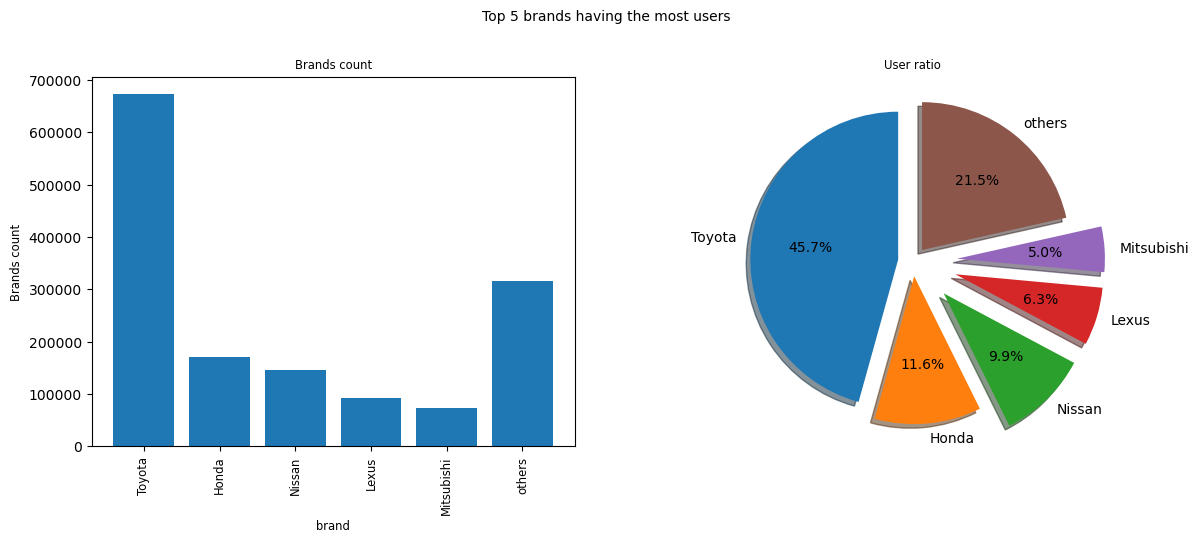

In [14]:
highest_brand_df_renamed = highest_brand_df
# Compute the percentage of top 5 workout type / total users
highest_brand_df['percentage'] = highest_brand_df['count'] \
    / total_brands * 100

# We assign the rest of users belong to another specific group that we call 'others'
others = {
      'brand': 'others'
    , 'count': total_brands - sum(highest_brand_df_renamed['count'])
    , 'percentage': 100 - sum(highest_brand_df_renamed['percentage'])
}

highest_brand_df_renamed = highest_brand_df_renamed.append(
    others, ignore_index=True
)
print('Top 5 brands that have the most users participated:')
highest_brand_df_renamed

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.35))

plot0 =   axs[0].bar(x=highest_brand_df_renamed['brand']
                     , height=highest_brand_df_renamed['count'])
title0 =  axs[0].set_title('Brands count', fontsize = 'small')
xlabel0 = axs[0].set_xlabel('brand', fontsize = 'small')
ylabel0 = axs[0].set_ylabel('Brands count', fontsize = 'small')
xsticks_label = axs[0].set_xticklabels(highest_brand_df_renamed['brand'] 
                                       ,rotation = 'vertical', fontsize='small')
explode = (0.1, 0.1, 0.3, 0.3, 0.3, 0.1)
title1 = axs[1].set_title('User ratio', fontsize = 'small')
plot1 = axs[1].pie(
      x=highest_brand_df_renamed['percentage']
    , labels=highest_brand_df_renamed['brand']
    , autopct='%1.1f%%', shadow=True, explode=explode, startangle=90
    , radius=1
)

text = fig.text(0.5, 1.02, 'Top 5 brands having the most users', ha='center', va='top', transform=fig.transFigure)

In [15]:
# Оставляем только следующие поля, приводим к нужному типу, строим графики
df = df.select("brand", "color", "fuelType", "year", "mileage", "transmission", "power", "price")
dfM = df.toPandas()
df_pyspark = df.withColumn("year",df.year.cast(DoubleType())) \
.withColumn("mileage",df.mileage.cast(DoubleType())) \
.withColumn("power",df.power.cast(DoubleType())) \
.withColumn("price",df.price.cast(DoubleType()))

In [16]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

categoricalColumns = ["brand", "color", "fuelType", "transmission"]

#define a list of stages in your pipeline. The string indexer will be one stage
stages = []

#iterate through all categorical values
for categoricalCol in categoricalColumns:
    #create a string indexer for those categorical values and assign a new name including the word 'Index'
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + '_i')

    #append the string Indexer to our list of stages
    stages += [stringIndexer]

#Create the pipeline. Assign the satges list to the pipeline key word stages
pipeline = Pipeline(stages = stages)
#fit the pipeline to our dataframe
pipelineModel = pipeline.fit(df_pyspark)
#transform the dataframe
df_pyspark= pipelineModel.transform(df_pyspark)

In [17]:
df_pyspark.show(10)

+-------------+--------+--------+------+--------+------------+-----+---------+-------+-------+----------+--------------+
|        brand|   color|fuelType|  year| mileage|transmission|power|    price|brand_i|color_i|fuelType_i|transmission_i|
+-------------+--------+--------+------+--------+------------+-----+---------+-------+-------+----------+--------------+
|Mercedes-Benz|Бордовый|  Бензин|2015.0| 57000.0|        АКПП|367.0|4600000.0|    8.0|    7.0|       0.0|           0.0|
|Mercedes-Benz|  Черный|  Бензин|2002.0|200000.0|        АКПП|296.0|2999999.0|    8.0|    1.0|       0.0|           0.0|
|        Lexus|Бордовый|  Бензин|2016.0|150000.0|        АКПП|301.0|3500000.0|    3.0|    7.0|       0.0|           0.0|
|       Nissan|   Серый|  Бензин|2016.0| 58000.0|    Вариатор| 79.0| 850000.0|    2.0|    2.0|       0.0|           1.0|
|       Toyota|   Белый|  Бензин|2017.0| 20000.0|        АКПП|231.0|3300000.0|    0.0|    0.0|       0.0|           0.0|
|       Nissan|Бордовый|  Бензин

array([[<AxesSubplot: title={'center': 'brand_i'}>]], dtype=object)

<AxesSubplot: xlabel='brand_i', ylabel='price'>

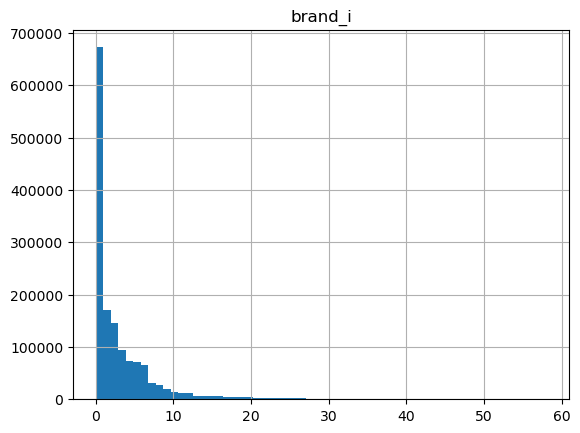

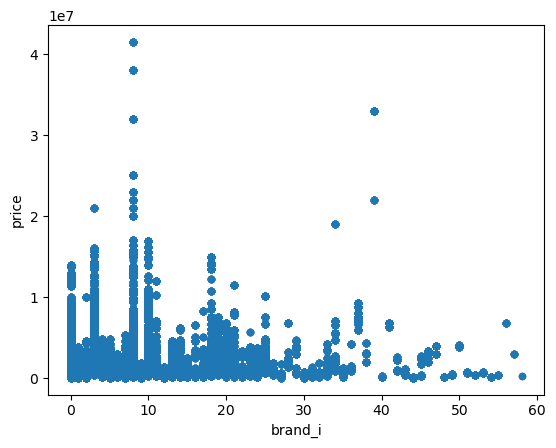

In [18]:
df_pyspark.select('brand_i').toPandas().hist(bins=60)
df_pyspark.select(col('brand_i'), col('price')).toPandas().plot.scatter(x='brand_i', y='price')

array([[<AxesSubplot: title={'center': 'color_i'}>]], dtype=object)

<AxesSubplot: xlabel='color_i', ylabel='price'>

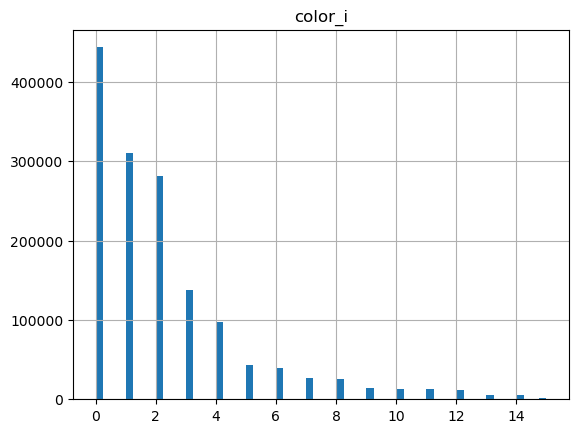

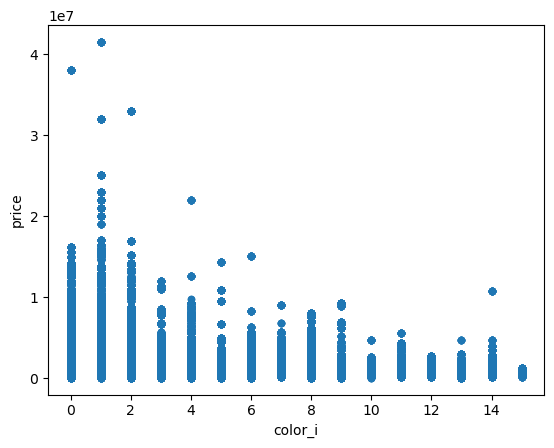

In [19]:
df_pyspark.select('color_i').toPandas().hist(bins=60)
df_pyspark.select(col('color_i'), col('price')).toPandas().plot.scatter(x='color_i', y='price')

array([[<AxesSubplot: title={'center': 'fuelType_i'}>]], dtype=object)

<AxesSubplot: xlabel='fuelType_i', ylabel='price'>

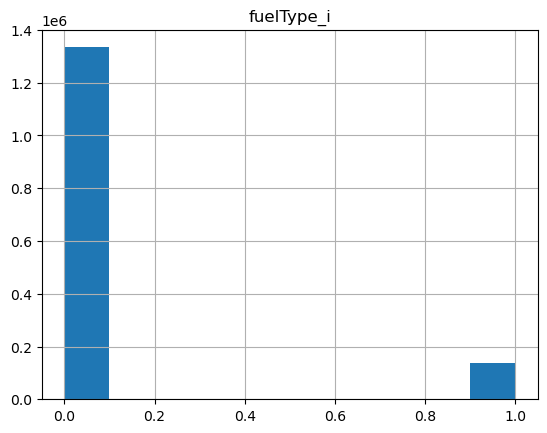

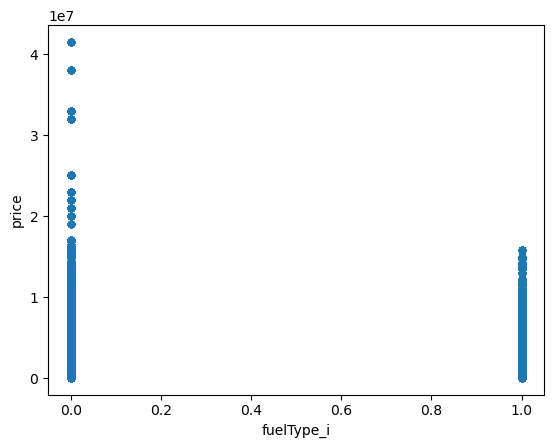

In [20]:
df_pyspark.select('fuelType_i').toPandas().hist(bins=10)
df_pyspark.select(col('fuelType_i'), col('price')).toPandas().plot.scatter(x='fuelType_i', y='price')

array([[<AxesSubplot: title={'center': 'year'}>]], dtype=object)

<AxesSubplot: xlabel='year', ylabel='price'>

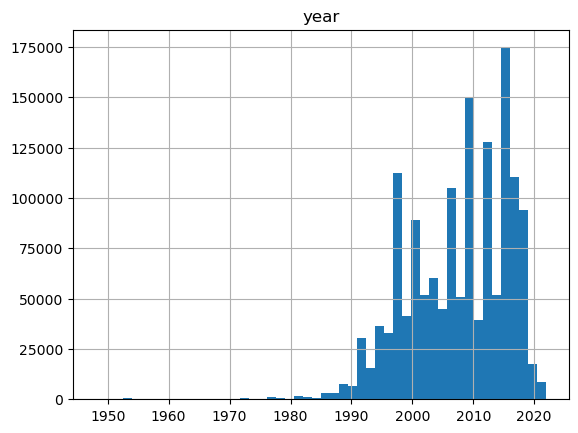

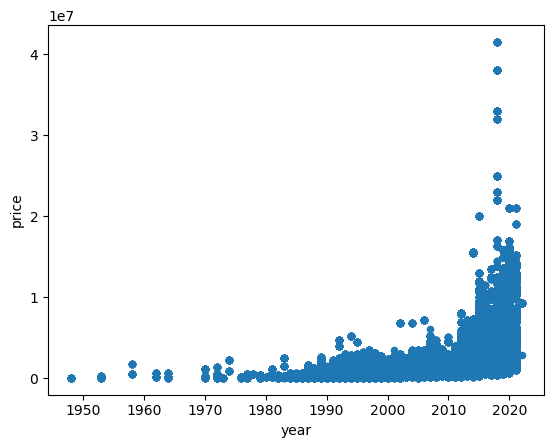

In [21]:
df_pyspark.select('year').toPandas().hist(bins=50)
df_pyspark.select(col('year'), col('price')).toPandas().plot.scatter(x='year', y='price')
maxY = df_pyspark.agg({"year": "max"}).collect()[0][0]
minY = df_pyspark.agg({"year": "min"}).collect()[0][0]
df_pyspark = df_pyspark.withColumn("year", ((df_pyspark.year - minY)/(maxY - minY)))

array([[<AxesSubplot: title={'center': 'mileage'}>]], dtype=object)

<AxesSubplot: xlabel='mileage', ylabel='price'>

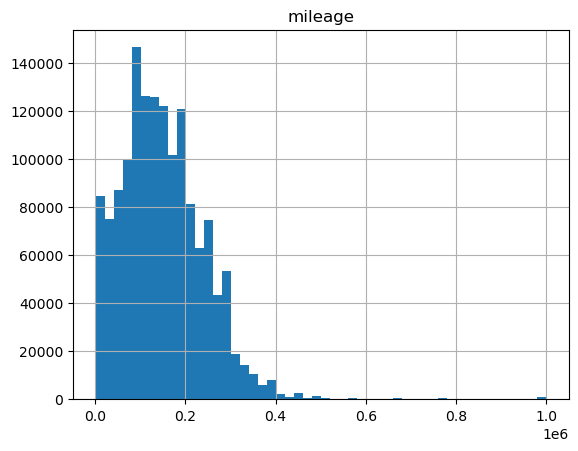

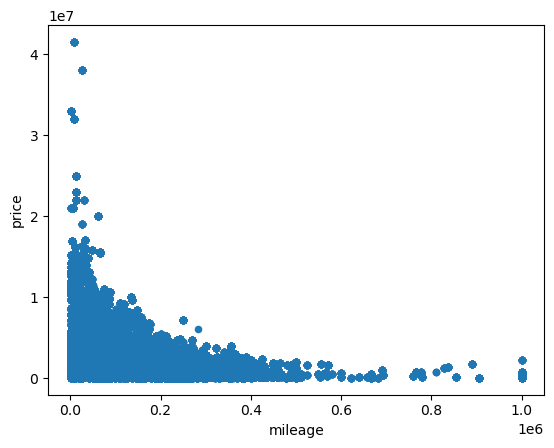

In [22]:
df_pyspark.select('mileage').toPandas().hist(bins=50)
df_pyspark.select(col('mileage'), col('price')).toPandas().plot.scatter(x='mileage', y='price')
maxY = df_pyspark.agg({"mileage": "max"}).collect()[0][0]
minY = df_pyspark.agg({"mileage": "min"}).collect()[0][0]
df_pyspark = df_pyspark.withColumn("mileage", ((df_pyspark.mileage - minY)/(maxY - minY)))

array([[<AxesSubplot: title={'center': 'transmission_i'}>]], dtype=object)

<AxesSubplot: xlabel='transmission_i', ylabel='price'>

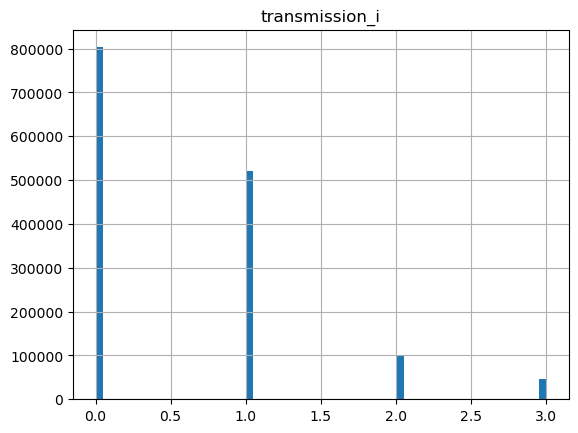

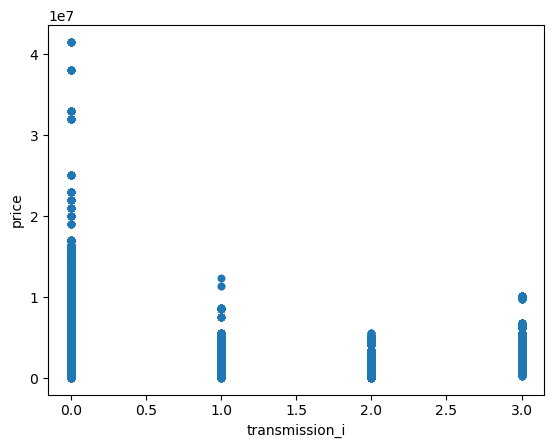

In [23]:
df_pyspark.select('transmission_i').toPandas().hist(bins=60)
df_pyspark.select(col('transmission_i'), col('price')).toPandas().plot.scatter(x='transmission_i', y='price')

array([[<AxesSubplot: title={'center': 'power'}>]], dtype=object)

<AxesSubplot: xlabel='power', ylabel='price'>

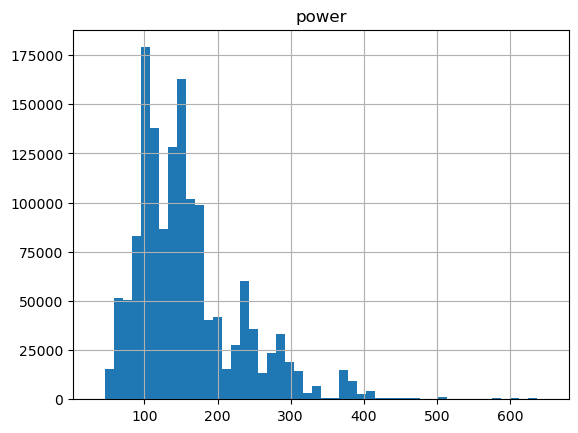

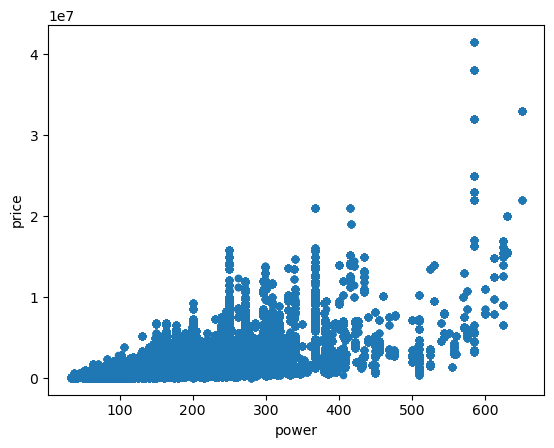

In [24]:
df_pyspark.select('power').toPandas().hist(bins=50)
df_pyspark.select(col('power'), col('price')).toPandas().plot.scatter(x='power', y='price')
maxY = df_pyspark.agg({"power": "max"}).collect()[0][0]
minY = df_pyspark.agg({"power": "min"}).collect()[0][0]
df_pyspark = df_pyspark.withColumn("power", ((df_pyspark.power - minY)/(maxY - minY)))

In [25]:
df_pyspark.show(3,False)

+-------------+--------+--------+------------------+--------------------+------------+-------------------+---------+-------+-------+----------+--------------+
|brand        |color   |fuelType|year              |mileage             |transmission|power              |price    |brand_i|color_i|fuelType_i|transmission_i|
+-------------+--------+--------+------------------+--------------------+------------+-------------------+---------+-------+-------+----------+--------------+
|Mercedes-Benz|Бордовый|Бензин  |0.9054054054054054|0.056056056056056056|АКПП        |0.5413290113452188 |4600000.0|8.0    |7.0    |0.0       |0.0           |
|Mercedes-Benz|Черный  |Бензин  |0.7297297297297297|0.1991991991991992  |АКПП        |0.42625607779578606|2999999.0|8.0    |1.0    |0.0       |0.0           |
|Lexus        |Бордовый|Бензин  |0.918918918918919 |0.14914914914914915 |АКПП        |0.4343598055105348 |3500000.0|3.0    |7.0    |0.0       |0.0           |
+-------------+--------+--------+-------------

array([[<AxesSubplot: title={'center': 'price'}>]], dtype=object)

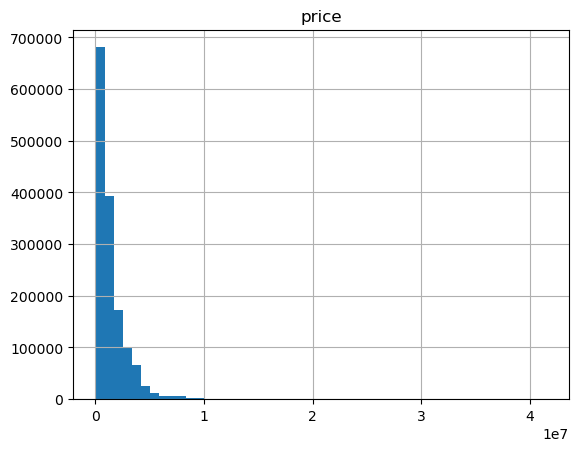

In [30]:
df_pyspark.select('price').toPandas().hist(bins=50)
df_pyspark = df_pyspark.withColumn("price", (df_pyspark.price/100000))

array([[<AxesSubplot: title={'center': 'price'}>]], dtype=object)

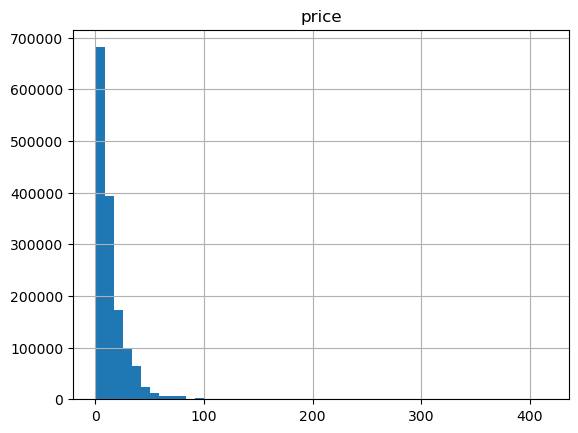

In [31]:
df_pyspark.select('price').toPandas().hist(bins=50)

In [32]:
df_pyspark.toPandas().corr(method='pearson').style.background_gradient(cmap='coolwarm')

/tmp/ipykernel_3758/804006378.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_pyspark.toPandas().corr(method='pearson').style.background_gradient(cmap='coolwarm')


In [33]:
df_pyspark.select("year", "mileage", "power", "price", df_pyspark.brand_i.alias("brand"), df_pyspark.color_i.alias("color"), \
                  df_pyspark.fuelType_i.alias("fuelType"), df_pyspark.transmission_i.alias("transmission")) \
                .repartition(1).write.parquet("./data/dataspark")